In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copairs import map

## Introduction

This example demostrates how to use `copairs` to:
- assess phenotypic activity of perturbations' replicates against DMSO control replicates and
- assess phenotypic consistncy of perturbations htat target the same gene against other perturbations.

Citation:
> Kalinin, A. A. et al. A versatile information retrieval framework for evaluating profile strength and similarity. bioRxiv, 2024-04, (2024).

In [2]:
# these imports are only needed for showing Figure 1 from the paper
import requests
from io import BytesIO
from pathlib import Path

from PIL import Image
from IPython.display import display

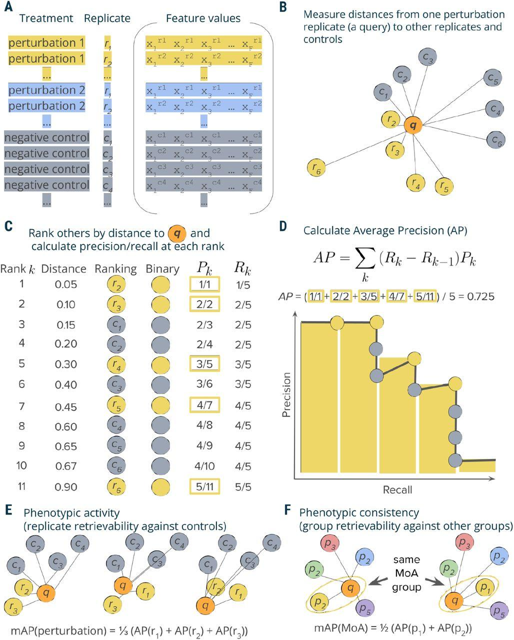

In [3]:
fig1_path = "F1.large.jpg"
fig1_url = "https://www.biorxiv.org/content/biorxiv/early/2024/04/02/2024.04.01.587631/F1.large.jpg"

if not Path(fig1_path).is_file():
    image = Image.open(BytesIO(requests.get(fig1_url).content))
    image.save(fig1_path)

image = Image.open(fig1_path).resize((514, 640))
display(image)

## Download data

Download a single plate of profiles from the dataset "cpg0004" (aka LINCS), which contains Cell Painting images of 1,327 small-molecule perturbations of A549 human cells. The wells on each plate were perturbed with 56 different compounds in six different doses.

> Way, G. P. et al. Morphology and gene expression profiling provide complementary information for mapping cell state. Cell Syst 13, 911–923.e9 (2022).

In [4]:
commit = "da8ae6a3bc103346095d61b4ee02f08fc85a5d98"
plate = "SQ00014812"
url = f"https://media.githubusercontent.com/media/broadinstitute/lincs-cell-painting/{commit}/profiles/2016_04_01_a549_48hr_batch1/{plate}/{plate}_normalized_feature_select.csv.gz"

df = pd.read_csv(url)
df = df.loc[:, df.nunique() > 1]  # remove constant columns
df

,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_broad_sample_type,Metadata_pert_type,Metadata_broad_id,Metadata_InChIKey14,...,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0
0,DMSO,0.000000,0.000000,NaN,NaN,A01,control,control,NaN,NaN,...,-1.3544,-1.07770,2.26020,-0.377010,-0.065840,2.12360,2.8740,2.87500,2.3047,-0.92358
1,DMSO,0.000000,0.000000,NaN,NaN,A02,control,control,NaN,NaN,...,-2.3840,-0.73440,1.12090,-0.182500,-0.061450,0.66985,2.3919,2.35230,1.8672,-0.11820
2,DMSO,0.000000,0.000000,NaN,NaN,A03,control,control,NaN,NaN,...,-1.9493,-0.36148,0.44050,0.326660,0.547200,0.25015,1.2271,0.77847,1.0651,-0.44810
3,DMSO,0.000000,0.000000,NaN,NaN,A04,control,control,NaN,NaN,...,-2.2909,-0.46380,0.96434,1.132200,0.753500,0.31403,1.4384,1.48110,1.2943,-0.83810
4,DMSO,0.000000,0.000000,NaN,NaN,A05,control,control,NaN,NaN,...,-1.8955,-1.05350,1.64840,0.057781,0.070229,1.60990,1.1296,0.90213,1.1016,0.53225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BRD-K82746043-001-15-1,3.248700,3.333300,BRD-K82746043,BRD-K82746043-001-15-1,P20,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-6.1522,1.81410,1.54220,-1.874700,-1.133900,1.57540,-3.0962,-3.25160,-2.7683,1.40170
380,BRD-K82746043-001-15-1,1.082900,1.111100,BRD-K82746043,BRD-K82746043-001-15-1,P21,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-5.1586,1.50580,1.68420,-1.126400,-1.066600,1.24740,-1.5305,-1.79020,-1.2474,1.17600
381,BRD-K82746043-001-15-1,0.360970,0.370370,BRD-K82746043,BRD-K82746043-001-15-1,P22,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-5.9475,1.42100,1.51020,-1.103600,-1.666500,1.19840,-2.6086,-2.97620,-2.0026,0.91557
382,BRD-K82746043-001-15-1,0.120320,0.123460,BRD-K82746043,BRD-K82746043-001-15-1,P23,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,...,-8.4408,2.99620,2.55230,-2.275200,-1.783500,2.49200,-4.3964,-4.19030,-3.8360,1.02240


Note that in this dataset, pertubations can target multiple genes. We can list these targets from the `Metadata_target` column.

In [5]:
df["Metadata_target"].unique()

array([nan, 'CHRM1|CHRM2|CHRM3|CHRM4|CHRM5', 'HMGCR',
       'HDAC1|HDAC2|HDAC3|HDAC9', 'ERBB2', 'DNMT1|DNMT3A',
       'GABRA1|GABRA2|GABRA3|GABRA4|GABRA5|GABRA6', 'TUBB', 'KIF11',
       'PSMA1|PSMA2|PSMA3|PSMA4|PSMA5|PSMA6|PSMA7|PSMA8|PSMB1|PSMB10|PSMB11|PSMB2|PSMB3|PSMB4|PSMB5|PSMB6|PSMB7|PSMB8|PSMB9|PSMD1|PSMD2|RELA',
       'SQLE', 'GABRA1', 'KCNT2|TRPV4', 'AURKA|AURKB',
       'DRD2|GRIN2A|GRIN2B|GRIN2C|GRIN2D|GRIN3A', 'CFTR',
       'CACNA1C|CACNA1S|CACNA2D1|CACNG1|HTR3A|KCNA5',
       'ADRA1A|ADRA1B|ADRA2A|ADRA2B|ADRA2C|CHRM1|CHRM2|CHRM3|CHRM4|CHRM5|DRD1|DRD2|DRD3|DRD4|DRD5|HRH1|HTR1A|HTR1B|HTR1D|HTR1E|HTR2A|HTR2C|HTR3A|HTR6|HTR7',
       'EGFR|NR1I2', 'ADRA1A|ADRA2A|HRH1|HTR1A|HTR2A|HTR2B|HTR2C|SLC6A4',
       'EGFR|ERBB2', 'HIF1A', 'ESR1|ESR2|MAP1A|MAP2', 'SCN4A|SCN9A',
       'BIRC2|XIAP', 'AKT1|AKT2|AKT3|PRKG1', 'ACE',
       'HTR1A|HTR1B|HTR1D|HTR1E|HTR1F|HTR2A|HTR2B|HTR2C|HTR5A|HTR6|HTR7',
       'CYSLTR1|CYSLTR2', 'GAST', 'HTR1A', 'PSMB1', 'MET', 'NAE1|UBA3',
       'VD

## Assessing phenotypic activity of compounds with mAP

Phenotypic activity of a perturbation reflects the average extent to which its replicate profiles are more similar to each other compared to control profiles (Figure 1E).

Here, we treat different doses of each compound as replicates and assess how well we can retrieve them by similarity against the group of negative controls (DMSO).

To ensure correct grouping of profiles, we can add a dummy column that is equal to row index for all compound replicates and to -1 for all DMSO replicates. 

In [6]:
df_activity = df.copy()
# make deafult value equal to row index
df_activity["Metadata_treatment_index"] = df_activity.index
# make index equal to -1 for all DMSO treatment replicates
df_activity.loc[df["Metadata_broad_sample"] == "DMSO", "Metadata_treatment_index"] = -1
# now all treatment replicates differ in the index column, except for DMSO replicates
df_activity.insert(
    0, "Metadata_treatment_index", df_activity.pop("Metadata_treatment_index")
)
df_activity

,Metadata_treatment_index,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_broad_sample_type,Metadata_pert_type,Metadata_broad_id,...,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0
0,-1,DMSO,0.000000,0.000000,NaN,NaN,A01,control,control,NaN,...,-1.3544,-1.07770,2.26020,-0.377010,-0.065840,2.12360,2.8740,2.87500,2.3047,-0.92358
1,-1,DMSO,0.000000,0.000000,NaN,NaN,A02,control,control,NaN,...,-2.3840,-0.73440,1.12090,-0.182500,-0.061450,0.66985,2.3919,2.35230,1.8672,-0.11820
2,-1,DMSO,0.000000,0.000000,NaN,NaN,A03,control,control,NaN,...,-1.9493,-0.36148,0.44050,0.326660,0.547200,0.25015,1.2271,0.77847,1.0651,-0.44810
3,-1,DMSO,0.000000,0.000000,NaN,NaN,A04,control,control,NaN,...,-2.2909,-0.46380,0.96434,1.132200,0.753500,0.31403,1.4384,1.48110,1.2943,-0.83810
4,-1,DMSO,0.000000,0.000000,NaN,NaN,A05,control,control,NaN,...,-1.8955,-1.05350,1.64840,0.057781,0.070229,1.60990,1.1296,0.90213,1.1016,0.53225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,379,BRD-K82746043-001-15-1,3.248700,3.333300,BRD-K82746043,BRD-K82746043-001-15-1,P20,trt,trt,BRD-K82746043,...,-6.1522,1.81410,1.54220,-1.874700,-1.133900,1.57540,-3.0962,-3.25160,-2.7683,1.40170
380,380,BRD-K82746043-001-15-1,1.082900,1.111100,BRD-K82746043,BRD-K82746043-001-15-1,P21,trt,trt,BRD-K82746043,...,-5.1586,1.50580,1.68420,-1.126400,-1.066600,1.24740,-1.5305,-1.79020,-1.2474,1.17600
381,381,BRD-K82746043-001-15-1,0.360970,0.370370,BRD-K82746043,BRD-K82746043-001-15-1,P22,trt,trt,BRD-K82746043,...,-5.9475,1.42100,1.51020,-1.103600,-1.666500,1.19840,-2.6086,-2.97620,-2.0026,0.91557
382,382,BRD-K82746043-001-15-1,0.120320,0.123460,BRD-K82746043,BRD-K82746043-001-15-1,P23,trt,trt,BRD-K82746043,...,-8.4408,2.99620,2.55230,-2.275200,-1.783500,2.49200,-4.3964,-4.19030,-3.8360,1.02240


Next, we define the rules by which profiles are grouped based on metadata:

* Two profiles are a positive pair if they belong to the same group that is not a control group. In this case, any two replicate profiles of the same compound are a positive pair. To define that using metadata columns, positive pairs should share the same value in the metadata column that identifies compounds (`Metadata_broad_sample`). We add this column to a list names `pos_sameby`.

* In this case, profiles that form a positive pair do not need to be different in any of the metatada columns, so we keep `pos_diffby` empty. Although one could define them as being from different batches, for instance, to account for batch effects.

* Two profiles are a negative pair when one of them belongs to a group of compound replicates and another to a group of DMSO controls. That means they should be different both in the metadata column that identifies the specific compound and the treatment index columns that we created. The latter is needed to ensure that replicates of compounds are retrieved against only DMSO controls at this stage (and not against replicates of other compounds). We list these columns in `neg_diffby`.

* Profiles that form a negative pair do not need to be same in any of the metatada columns, so we keep `neg_sameby` empty.

In [7]:
# positive pairs are replicates of the same treatment
pos_sameby = ["Metadata_broad_sample"]
pos_diffby = []

neg_sameby = []
# negative pairs are replicates of different treatments
neg_diffby = ["Metadata_broad_sample", "Metadata_treatment_index"]

Now we can use `average_precision` function to calculate the average precision score for each replicate of each compound.

It returns metadata with 3 new columns: number of positive and negative pairs for each replicate profile and the average precision score.

In [8]:
metadata = df_activity.filter(regex="^Metadata")
profiles = df_activity.filter(regex="^(?!Metadata)").values

replicate_aps = map.average_precision(
    metadata, profiles, pos_sameby, pos_diffby, neg_sameby, neg_diffby
)
replicate_aps = replicate_aps.query("Metadata_broad_sample != 'DMSO'")  # remove DMSO
replicate_aps

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,Metadata_treatment_index,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_broad_sample_type,Metadata_pert_type,Metadata_broad_id,Metadata_InChIKey14,Metadata_moa,Metadata_target,Metadata_broad_date,Metadata_Well,n_pos_pairs,n_total_pairs,average_precision
6,6,BRD-K74363950-004-01-0,5.655600,10.000000,BRD-K74363950,BRD-K74363950-004-01-0,A07,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A07,5,383,0.050922
7,7,BRD-K74363950-004-01-0,1.885200,3.333300,BRD-K74363950,BRD-K74363950-004-01-0,A08,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A08,5,383,0.308904
8,8,BRD-K74363950-004-01-0,0.628400,1.111100,BRD-K74363950,BRD-K74363950-004-01-0,A09,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A09,5,383,0.412513
9,9,BRD-K74363950-004-01-0,0.209470,0.370370,BRD-K74363950,BRD-K74363950-004-01-0,A10,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A10,5,383,0.377730
10,10,BRD-K74363950-004-01-0,0.069823,0.123460,BRD-K74363950,BRD-K74363950-004-01-0,A11,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,A11,5,383,0.715591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,379,BRD-K82746043-001-15-1,3.248700,3.333300,BRD-K82746043,BRD-K82746043-001-15-1,P20,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P20,5,383,0.726786
380,380,BRD-K82746043-001-15-1,1.082900,1.111100,BRD-K82746043,BRD-K82746043-001-15-1,P21,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P21,5,383,0.658824
381,381,BRD-K82746043-001-15-1,0.360970,0.370370,BRD-K82746043,BRD-K82746043-001-15-1,P22,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P22,5,383,0.517619
382,382,BRD-K82746043-001-15-1,0.120320,0.123460,BRD-K82746043,BRD-K82746043-001-15-1,P23,trt,trt,BRD-K82746043,JLYAXFNOILIKPP,BCL inhibitor,BCL2|BCL2L1|BCL2L2,broad_id_20170327,P23,5,383,0.543290


At the next step, we average replicate AP scores at the per-compound level to obtain mAP values using `mean_average_precision`.

It also calculates p-values using permutation testing, and performs FDR correction to compare across compounds.

In [9]:
replicate_maps = map.mean_average_precision(
    replicate_aps, pos_sameby, null_size=10000, threshold=0.05, seed=0
)
replicate_maps["-log10(p-value)"] = -replicate_maps["corrected_p_value"].apply(np.log10)
replicate_maps.head(10)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

,Metadata_broad_sample,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,-log10(p-value)
0,BRD-A69275535-001-01-5,0.203576,0.012899,0.016390,True,True,1.785430
1,BRD-A69636825-003-04-7,0.269093,0.000800,0.001365,True,True,2.865004
2,BRD-A69815203-001-07-6,0.862226,0.000100,0.000276,True,True,3.558835
3,BRD-A70858459-001-01-7,0.351816,0.000200,0.000400,True,True,3.397983
4,BRD-A72309220-001-04-1,0.263986,0.000900,0.001491,True,True,2.826441
5,BRD-A72390365-001-15-2,0.554667,0.000100,0.000276,True,True,3.558835
6,BRD-A73368467-003-17-6,0.788666,0.000100,0.000276,True,True,3.558835
7,BRD-A74980173-001-11-9,0.500600,0.000100,0.000276,True,True,3.558835
8,BRD-A81233518-004-16-1,0.140208,0.015598,0.018700,True,True,1.728154
9,BRD-A82035391-001-02-7,0.052362,0.077692,0.078692,False,False,1.104069


Finally, we can plot the results and filter out phenotypicall inactive compounds with corrected p-value >0.05.

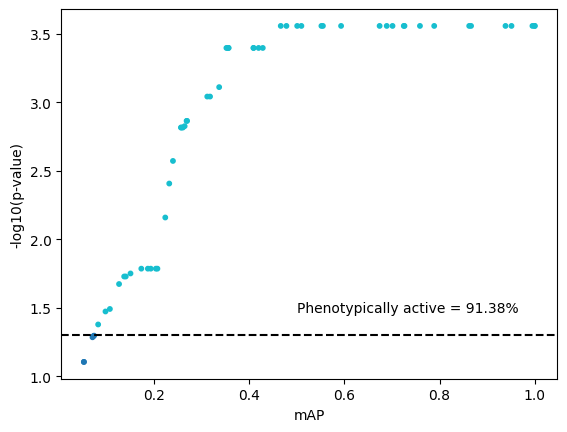

In [10]:
active_ratio = replicate_maps.below_corrected_p.mean()

plt.scatter(
    data=replicate_maps,
    x="mean_average_precision",
    y="-log10(p-value)",
    c="below_corrected_p",
    cmap="tab10",
    s=10,
)
# 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r',
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(
    0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left"
)
plt.show()

## Assessing phenotypic consistency of compounds grouped by targets

Phenotypic consitency of a group of perturbations reflects the average extent to which members of this group are more similar to each other compared to other groups (see Figure 1F).

First, we are going to filter out compounds that were not phenotypically active using mAP p-values from the previous section.

Next, we will aggregate each compound’s replicate profiles into a "consensus" profile by taking the median of each feature to reduce profile noise and improve computational efficiency.

In [11]:
# only keep active compounds, i.e. those with corrected p-value < 0.05
active_compounds = replicate_maps.query("below_corrected_p")["Metadata_broad_sample"]
df_consistent = df.query("Metadata_broad_sample in @active_compounds")
df_consistent.head(7)

,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_broad_sample_type,Metadata_pert_type,Metadata_broad_id,Metadata_InChIKey14,...,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0
6,BRD-K74363950-004-01-0,5.655600,10.000000,BRD-K74363950,BRD-K74363950-004-01-0,A07,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,...,-0.51038,-0.76402,1.616400,-0.49600,-0.481360,2.421100,1.10790,1.13820,1.14320,0.329230
7,BRD-K74363950-004-01-0,1.885200,3.333300,BRD-K74363950,BRD-K74363950-004-01-0,A08,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,...,-0.23602,-0.41129,0.304960,0.47884,0.005852,-0.710330,0.41986,-0.23888,0.54949,-0.092826
8,BRD-K74363950-004-01-0,0.628400,1.111100,BRD-K74363950,BRD-K74363950-004-01-0,A09,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,...,-0.52939,-0.54727,0.722570,0.73399,0.223850,0.035842,0.33318,0.39064,0.42969,-0.811390
9,BRD-K74363950-004-01-0,0.209470,0.370370,BRD-K74363950,BRD-K74363950-004-01-0,A10,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,...,-0.58515,-0.41533,0.044874,0.76374,0.062913,-0.656850,0.18149,-0.10960,0.48699,-0.345260
10,BRD-K74363950-004-01-0,0.069823,0.123460,BRD-K74363950,BRD-K74363950-004-01-0,A11,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,...,-0.52686,-0.57823,0.591610,0.85184,0.560370,0.039184,0.59864,0.44123,0.75783,-0.018031
11,BRD-K74363950-004-01-0,0.023274,0.041152,BRD-K74363950,BRD-K74363950-004-01-0,A12,trt,trt,BRD-K74363950,ASMXXROZKSBQIH,...,-0.48060,-1.47220,0.814150,0.79463,0.089249,0.072240,0.91828,0.39626,1.09120,-0.243750
12,BRD-K75958547-238-01-0,4.615400,10.000000,BRD-K75958547,BRD-K75958547-238-01-0,A13,trt,trt,BRD-K75958547,VGYFMXBACGZSIL,...,-5.89680,-0.97404,-5.025000,-10.41400,-6.067500,7.625700,3.31830,3.27410,-2.12240,2.299300


In [12]:
# aggregate replicates by taking the median of each feature
feature_cols = [c for c in df_consistent.columns if not c.startswith("Metadata")]
df_consistent = df_consistent.groupby(
    ["Metadata_broad_sample", "Metadata_target"], as_index=False
)[feature_cols].median()
df_consistent["Metadata_target"] = df_consistent["Metadata_target"].str.split("|")
df_consistent.head()

,Metadata_broad_sample,Metadata_target,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0
0,BRD-A69636825-003-04-7,"[CACNA1C, CACNA1S, CACNA2D1, CACNG1, HTR3A, KC...",-0.326365,0.651610,0.211280,0.092412,0.456915,0.486515,0.435545,0.863160,...,0.175200,0.557360,-0.859465,0.409045,0.201909,-1.003185,-1.405850,-1.495100,-0.867225,-0.066115
1,BRD-A69815203-001-07-6,"[ABCB11, CAMLG, FPR1, PPIA, PPIF, PPP3CA, PPP3...",2.487450,-2.872750,0.616635,-0.451942,-2.260100,-3.300900,0.316320,-1.825400,...,-2.681800,-0.197230,-4.717350,0.644170,1.324100,0.103070,0.986025,1.346200,0.773450,-2.749350
2,BRD-A70858459-001-01-7,"[ESR1, ESR2, MAP1A, MAP2]",-0.920210,1.461550,0.445630,-0.394235,1.528450,1.116100,-0.054990,1.061270,...,0.238875,0.326475,0.064563,0.187646,0.200447,-0.695660,0.100225,0.401885,0.114583,-0.245753
3,BRD-A72309220-001-04-1,"[HTR1A, HTR1B, HTR1D, HTR1E, HTR1F, HTR2A, HTR...",0.045435,0.099755,0.103628,0.592620,-0.352200,0.202930,-0.059855,-0.353755,...,1.069575,-0.475915,-0.174002,0.217965,0.090715,-0.154695,0.165235,-0.160191,0.242195,-0.126886
4,BRD-A73368467-003-17-6,[HRH1],-0.062074,-0.314820,0.526190,-0.502485,-0.444675,-0.191225,0.145019,0.018870,...,0.527805,-1.204250,0.615420,-0.187645,0.321880,1.013235,0.793675,0.682925,1.075500,0.844115


Now, we again use metadata columns to define grouping of profiles. Here, we'd like to group those compounds that share a target and assess their similarity against compounds that do not have the same target:

* Two compound profiles are a positive pair if they share the same target. To define that using metadata columns, positive pairs should share the same value in the metadata column that identifies targets (`Metadata_target`). We add this column to a list names `pos_sameby`.

* In this case, profiles that form a positive pair do not need to be different in any of the metatada columns, so we keep `pos_diffby` empty. Although one could define them as being structurally different, for example.

* Two profiles are a negative pair when do not share a common target. That means they should be different in the metadata column that identifies targets (`Metadata_target`).

* Profiles that form a negative pair do not need to be same in any of the metatada columns, so we keep `neg_sameby` empty.

We use `map.multilabel.average_precision` because each compound can have more than one target. If that's not the case, the standard `map.average_precision` should be used instead.

In [13]:
# positive pairs are compounds that share a target
pos_sameby = ["Metadata_target"]
pos_diffby = []

neg_sameby = []
# negative pairs are compounds that do not share a target
neg_diffby = ["Metadata_target"]

metadata = df_consistent.filter(regex="^Metadata")
profiles = df_consistent.filter(regex="^(?!Metadata)").values

target_aps = map.multilabel.average_precision(
    metadata,
    profiles,
    pos_sameby=pos_sameby,
    pos_diffby=pos_diffby,
    neg_sameby=neg_sameby,
    neg_diffby=neg_diffby,
    multilabel_col="Metadata_target",
)
target_aps

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,Metadata_broad_sample,average_precision,n_pos_pairs,n_total_pairs,Metadata_target
54,BRD-A69636825-003-04-7,0.500000,1,46,HTR3A
34,BRD-A72309220-001-04-1,0.396412,4,46,HTR1A
39,BRD-A72309220-001-04-1,0.142857,1,43,HTR1B
41,BRD-A72309220-001-04-1,0.142857,1,43,HTR1D
43,BRD-A72309220-001-04-1,0.142857,1,43,HTR1E
...,...,...,...,...,...
16,BRD-K74363950-004-01-0,0.094538,2,46,CHRM3
19,BRD-K74363950-004-01-0,0.094538,2,46,CHRM4
22,BRD-K74363950-004-01-0,0.094538,2,46,CHRM5
28,BRD-K76908866-001-07-6,0.500000,1,46,ERBB2


Then, we can compute mAP scores and p-values for each target group.

In [14]:
target_maps = map.mean_average_precision(
    target_aps, pos_sameby, null_size=10000, threshold=0.05, seed=0
)
target_maps["-log10(p-value)"] = -target_maps["corrected_p_value"].apply(np.log10)
target_maps.head(10)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

,Metadata_target,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,-log10(p-value)
0,ADRA1A,0.238095,0.104890,0.167542,False,False,0.775876
1,ADRA2A,0.238095,0.104890,0.167542,False,False,0.775876
2,AURKA,0.625000,0.022298,0.100340,True,False,0.998526
3,BIRC2,0.051316,0.413459,0.483152,False,False,0.315917
4,CHRM1,0.091024,0.483152,0.483152,False,False,0.315917
5,CHRM2,0.091024,0.483152,0.483152,False,False,0.315917
6,CHRM3,0.091024,0.483152,0.483152,False,False,0.315917
7,CHRM4,0.091024,0.483152,0.483152,False,False,0.315917
8,CHRM5,0.091024,0.483152,0.483152,False,False,0.315917
9,DRD2,0.750000,0.000900,0.006074,True,True,2.216497


Similarly, we can plot the results, where groups of compounds targeting the same gene are called consistent if their corrected p-value < 0.05.

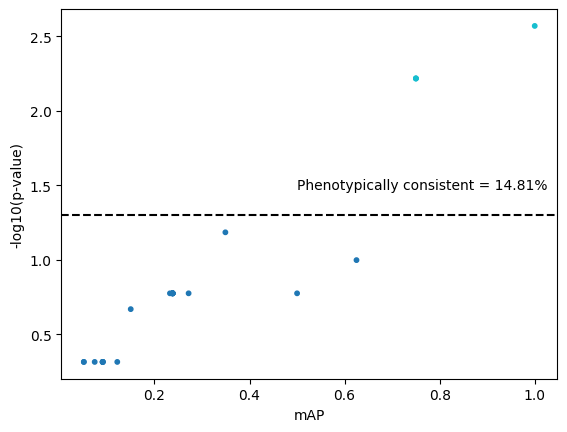

In [15]:
consistent_ratio = target_maps.below_corrected_p.mean()

plt.scatter(
    data=target_maps,
    x="mean_average_precision",
    y="-log10(p-value)",
    c="below_corrected_p",
    cmap="tab10",
    s=10,
)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(
    0.5,
    1.5,
    f"Phenotypically consistent = {100*consistent_ratio:.2f}%",
    va="center",
    ha="left",
)

plt.show()

Now we can list compounds that are phenotypically active and consistent.

Note that in multi-label scenario, when each compound can have multiple targets, the same compound can have "consistent" response in respect to one target, but not another.

In [16]:
consistent_targets = target_maps.query("below_corrected_p")["Metadata_target"]
consistent_compounds = df_consistent[
    df_consistent["Metadata_target"].apply(
        lambda x: any(t in x for t in consistent_targets)
    )
]["Metadata_broad_sample"]

print(f"Phenotypically consistent targets: {consistent_targets.str.cat(sep=', ')}")
print(f"Phenotypically consistent compounds: {consistent_compounds.str.cat(sep=', ')}")

Phenotypically consistent targets: DRD2, EGFR, HTR3A, PSMB1
Phenotypically consistent compounds: BRD-A69636825-003-04-7, BRD-K50691590-001-02-2, BRD-K60230970-001-10-0, BRD-K70330367-003-07-9, BRD-K70358946-001-15-7, BRD-K70401845-003-09-6, BRD-K70914287-300-02-8
